(401, 90)
torch.Size([1, 1, 401, 90])


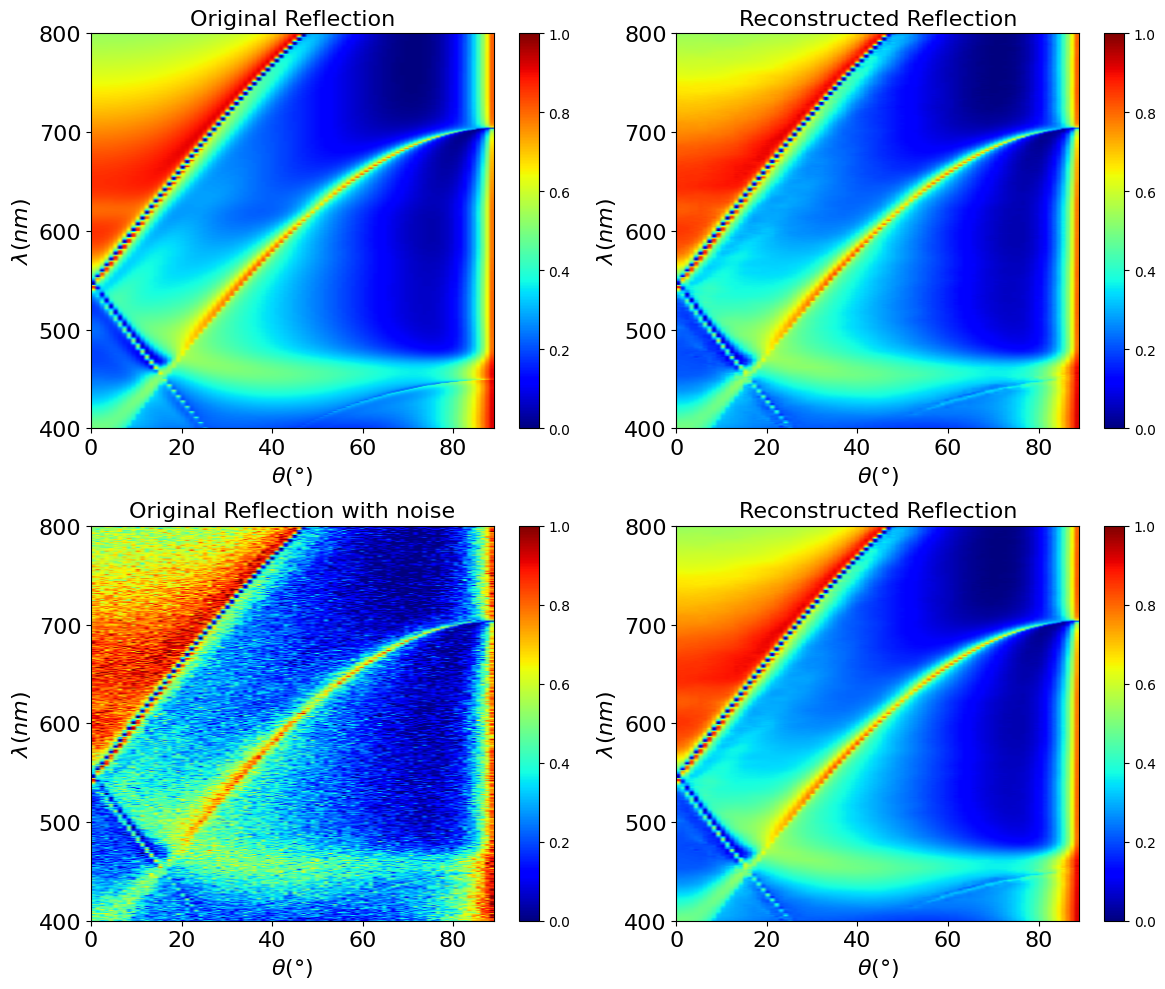

In [1]:
#Autoencoder reconstruction 
import torch
import os
import cv2
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import sys
sys.path.append('/path to codes/')
from Models import Autoencoder
    
def add_random_noise(x, noise_min=0.0, noise_max=0.1): #noise added to the reflection data
    noise_levels = torch.rand(x.size(0), device=x.device) * (noise_max - noise_min) + noise_min 
    noise_levels = noise_levels.view(-1, *[1] * (x.ndim - 1))
    noise = torch.randn_like(x) * noise_levels
    x_noisy = x + noise
    return x_noisy
    
def load_model_and_reconstruct(input_tensor, model_path='/path to the model/autoencoder_model_128_noise.pth', latent_dim=128, device='cpu'):
    model = Autoencoder(latent_dim=latent_dim)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        reconstructed, latent_vector = model(input_tensor)
    return reconstructed, latent_vector

def plot_reflection_and_reconstruction(original, reconstructed, noisy, reconstructed_noisy):
    original = original.squeeze().cpu().numpy()
    reconstructed = reconstructed.squeeze().cpu().numpy()
    noisy = noisy.squeeze().cpu().numpy()
    reconstructed_noisy = reconstructed_noisy.squeeze().cpu().numpy()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    yticks = np.arange(400, 801, 100)

    im1 = axes[0, 0].imshow(original, cmap='jet', aspect='auto',extent=[0, 89, 400, 800], origin='lower', vmin = 0, vmax = 1)
    fig.colorbar(im1, ax=axes[0, 0])
    axes[0, 0].set_title("Original Reflection", size=16)
    axes[0, 0].set_xlabel(rf"$\theta (\degree)$", size=16)
    axes[0, 0].set_ylabel(rf"$\lambda (nm)$", size=16)
    axes[0, 0].set_yticks(yticks)
    axes[0, 0].tick_params(axis='both', which='major', labelsize=16)

    im2 = axes[0, 1].imshow(reconstructed, cmap='jet', aspect='auto',extent=[0, 89, 400, 800], origin='lower', vmin = 0, vmax = 1)
    fig.colorbar(im2, ax=axes[0, 1])
    axes[0, 1].set_title("Reconstructed Reflection", size=16)
    axes[0, 1].set_xlabel(rf"$\theta (\degree)$", size=16)
    axes[0, 1].set_ylabel(rf"$\lambda (nm)$", size=16)
    axes[0, 1].set_yticks(yticks)
    axes[0, 1].tick_params(axis='both', which='major', labelsize=16)

    im3 = axes[1, 0].imshow(noisy, cmap='jet', aspect='auto',extent=[0, 89, 400, 800], origin='lower', vmin = 0, vmax = 1)
    fig.colorbar(im3, ax=axes[1, 0])
    axes[1, 0].set_title("Original Reflection with noise", size=16)
    axes[1, 0].set_xlabel(rf"$\theta (\degree)$", size=16)
    axes[1, 0].set_ylabel(rf"$\lambda (nm)$", size=16)
    axes[1, 0].set_yticks(yticks)
    axes[1, 0].tick_params(axis='both', which='major', labelsize=16)

    im4 = axes[1, 1].imshow(reconstructed_noisy, cmap='jet', aspect='auto',extent=[0, 89, 400, 800], origin='lower', vmin = 0, vmax = 1)
    fig.colorbar(im4, ax=axes[1, 1])
    axes[1, 1].set_title("Reconstructed Reflection", size=16)
    axes[1, 1].set_xlabel(rf"$\theta (\degree)$", size=16)
    axes[1, 1].set_ylabel(rf"$\lambda (nm)$", size=16)
    axes[1, 1].set_yticks(yticks)
    axes[1, 1].tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()
    # plt.savefig('autoencoder-outputs.png', dpi=600)
    plt.show()

if __name__ == "__main__":

    reflection = pd.read_csv(f"/path to the data/Reflection_TM_11499.csv", header=None)
    reflection = reflection.iloc[1:, 1:].astype(float)
    reflection = reflection.values
    print(reflection.shape)
    reflection_tensor = torch.tensor(reflection, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  
    print(reflection_tensor.shape)
    noisy_reflection_tensor = add_random_noise(reflection_tensor, noise_min=0.0, noise_max=0.1)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    reconstructed_output_c, latent_vector_c = load_model_and_reconstruct(reflection_tensor, device=device)
    reconstructed_output_n, latent_vector_n = load_model_and_reconstruct(noisy_reflection_tensor, device=device)
    plot_reflection_and_reconstruction(reflection_tensor, reconstructed_output_c, noisy_reflection_tensor, reconstructed_output_n)